# Preprocessing

In [1]:
%matplotlib inline

import time
import os

import sqlite3

import pandas as pd
import numpy as np
import scipy as sp

import scipy.signal as sig
import pywt # PyWavelets

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import seaborn as sns

## Axes combination

Load table of unprocessed accelerometer data.

In [2]:
dbase = sqlite3.connect("disco_parser.db")
dframe = pd.read_sql_query("SELECT * FROM unprocessed",dbase)
dbase.close()

In [3]:
dframe.head()

,id,t,x,y,z
0,1a,55544529,-0.833,0.151,0.054
1,1a,55544606,-0.848,0.218,0.078
2,1a,55544610,-0.844,0.300,0.074
3,1a,55544612,-0.833,0.313,0.093
4,1a,55544617,-0.835,0.261,0.132


Line chart of the three accelerometer axes. (*Subject:* 1a)

In [2]:
# Load accelerometer data for subject
subject = '1a'
db = sqlite3.connect("disco_parser.db")
df0 = pd.read_sql_query("SELECT id, t, x, y, z FROM unprocessed WHERE id == '"+subject+"'",db)
db.close()

In [3]:
# Fill in missing samples with NaNs
t = np.arange(df0['t'].values[0],df0['t'].values[-1])
v1 = v2 = v3 = np.empty(len(t)); v1[:] = v2[:] = v3[:] = np.NAN
df1 = pd.DataFrame(dict(t=t,x0=v1,y0=v2,z0=v3)) 
df2 = df0[['t','x','y','z']]
df = df1.merge(df2,how='left',left_on='t',right_on='t')
df = df[['t','x','y','z']]

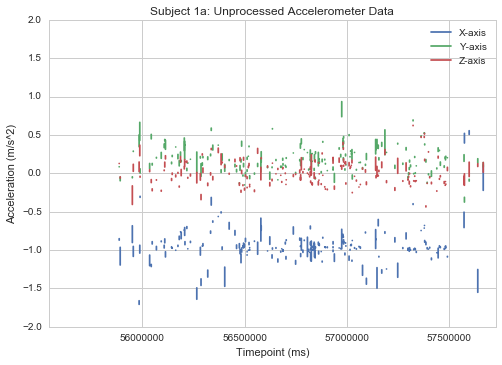

In [4]:
start,end = 55544580,57725830 # Session start and end times
first,last = np.where(df['t']==start)[0][0],np.where(df['t']==end)[0][0]+1
T = df['t'][first:last].values # Milliseconds
X = df['x'][first:last].values # X-axis
Y = df['y'][first:last].values # Y-axis
Z = df['z'][first:last].values # Z-axis

with sns.axes_style("whitegrid"):
    
    fig = plt.figure(); plt.clf()
    
    plt.plot(T,X,label='X-axis')
    plt.plot(T,Y,label='Y-axis')
    plt.plot(T,Z,label='Z-axis')      
    
    plt.axis([start,end,-2,2])    
    plt.ticklabel_format(style='plain',axis='x')
    
    plt.legend()
    plt.xlabel("Timepoint (ms)")
    plt.ylabel("Acceleration (m/s^2)")
    plt.title("Subject "+subject+": Unprocessed Accelerometer Data")
    
    plt.show()

Combine the three axis measures into one timeseries. (*Options:* vector, xalign, yalign, zalign)

In [4]:
def disco_combine(inputdata,outputdir,combotype):
    ''' Combines the three axis measures into one measure
    inputdata = Input data table (id,t,x,y,z)
    outputdir = Output data directory
    combotype = Combination type ('vector','xalign','yalign','zalign')
    Returns: timeseries = Combined axis values (id,t,v) '''
    
    function = 'disco_combine'
    print(time.strftime("%m/%d/%Y"),time.strftime("%H:%M:%S"),'Running',function,combotype)
    
    subjects = inputdata.id.unique()
        
    if combotype == 'vector': # SQRT(X^2 + Y^2 + Z^2)        
        timeseries = pd.DataFrame({})
        for s in subjects:
            print(time.strftime("%m/%d/%Y"),time.strftime("%H:%M:%S"),s)
            x = inputdata[inputdata.id == s].x.values
            y = inputdata[inputdata.id == s].y.values
            z = inputdata[inputdata.id == s].z.values
            
            v = np.sqrt(x**2 + y**2 + z**2)
            
            temp = pd.DataFrame({'id':inputdata[inputdata.id == s].id,
                                 't':inputdata[inputdata.id == s].t,
                                 'v':v})
            timeseries = pd.concat([timeseries,temp])
    
    elif combotype == 'xalign': # ARCSIN(X / SQRT(X^2 + Y^2 + Z^2))
        timeseries = pd.DataFrame({})
        for s in subjects:
            print(time.strftime("%m/%d/%Y"),time.strftime("%H:%M:%S"),s)
            x = inputdata[inputdata.id == s].x.values
            y = inputdata[inputdata.id == s].y.values
            z = inputdata[inputdata.id == s].z.values
            
            v = np.arcsin(x / np.sqrt(x**2 + y**2 + z**2))
            
            temp = pd.DataFrame({'id':inputdata[inputdata.id == s].id,
                                 't':inputdata[inputdata.id == s].t,
                                 'v':v})
            timeseries = pd.concat([timeseries,temp])
    
    elif combotype == 'yalign': # ARCSIN(Y / SQRT(X^2 + Y^2 + Z^2))
        timeseries = pd.DataFrame({})
        for s in subjects:
            print(time.strftime("%m/%d/%Y"),time.strftime("%H:%M:%S"),s)
            x = inputdata[inputdata.id == s].x.values
            y = inputdata[inputdata.id == s].y.values
            z = inputdata[inputdata.id == s].z.values
            
            v = np.arcsin(y / np.sqrt(x**2 + y**2 + z**2))
            
            temp = pd.DataFrame({'id':inputdata[inputdata.id == s].id,
                                 't':inputdata[inputdata.id == s].t,
                                 'v':v})
            timeseries = pd.concat([timeseries,temp])
    
    elif combotype == 'zalign': # ARCSIN(Z / SQRT(X^2 + Y^2 + Z^2)) 
        timeseries = pd.DataFrame({})
        for s in subjects:
            print(time.strftime("%m/%d/%Y"),time.strftime("%H:%M:%S"),s)
            x = inputdata[inputdata.id == s].x.values
            y = inputdata[inputdata.id == s].y.values
            z = inputdata[inputdata.id == s].z.values
            
            v = np.arcsin(z / np.sqrt(x**2 + y**2 + z**2))
            
            temp = pd.DataFrame({'id':inputdata[inputdata.id == s].id,
                                 't':inputdata[inputdata.id == s].t,
                                 'v':v})
            timeseries = pd.concat([timeseries,temp])
    
    print(time.strftime("%m/%d/%Y"),time.strftime("%H:%M:%S"),'Saving',function+'_'+combotype+'.pkl')
    timeseries.to_pickle(os.path.join('.',outputdir,function+'_'+combotype+'.pkl'))
    
    print(time.strftime("%m/%d/%Y"),time.strftime("%H:%M:%S"),'Done') 
    return timeseries

In [5]:
vector = disco_combine(dframe,'','vector')
xalign = disco_combine(dframe,'','xalign')
yalign = disco_combine(dframe,'','yalign')
zalign = disco_combine(dframe,'','zalign')

11/08/2016 12:59:18 Running disco_combine vector
11/08/2016 12:59:19 1a
11/08/2016 12:59:19 1b
11/08/2016 12:59:20 2a
11/08/2016 12:59:21 2b
11/08/2016 12:59:21 3a
11/08/2016 12:59:22 3b
11/08/2016 12:59:23 4a
11/08/2016 12:59:23 4b
11/08/2016 12:59:24 5b
11/08/2016 12:59:25 6a
11/08/2016 12:59:26 6b
11/08/2016 12:59:26 Saving disco_combine_vector.pkl
11/08/2016 12:59:28 Done
11/08/2016 12:59:28 Running disco_combine xalign
11/08/2016 12:59:28 1a
11/08/2016 12:59:28 1b
11/08/2016 12:59:29 2a
11/08/2016 12:59:30 2b
11/08/2016 12:59:30 3a
11/08/2016 12:59:31 3b
11/08/2016 12:59:32 4a
11/08/2016 12:59:33 4b
11/08/2016 12:59:33 5b
11/08/2016 12:59:34 6a
11/08/2016 12:59:35 6b
11/08/2016 12:59:36 Saving disco_combine_xalign.pkl
11/08/2016 12:59:37 Done
11/08/2016 12:59:37 Running disco_combine yalign
11/08/2016 12:59:37 1a
11/08/2016 12:59:38 1b
11/08/2016 12:59:38 2a
11/08/2016 12:59:39 2b
11/08/2016 12:59:40 3a
11/08/2016 12:59:40 3b
11/08/2016 12:59:41 4a
11/08/2016 12:59:42 4b
11/08/201

In [6]:
vector.head()

,id,t,v
0,1a,55544529,0.848296
1,1a,55544606,0.879040
2,1a,55544610,0.898784
3,1a,55544612,0.894711
4,1a,55544617,0.884743


In [7]:
xalign.head()

,id,t,v
0,1a,55544529,-1.380608
1,1a,55544606,-1.304258
2,1a,55544610,-1.219847
3,1a,55544612,-1.197218
4,1a,55544617,-1.233875


In [8]:
yalign.head()

,id,t,v
0,1a,55544529,0.178958
1,1a,55544606,0.250613
2,1a,55544610,0.340315
3,1a,55544612,0.357394
4,1a,55544617,0.299457


In [9]:
zalign.head()

,id,t,v
0,1a,55544529,0.063700
1,1a,55544606,0.088850
2,1a,55544610,0.082427
3,1a,55544612,0.104132
4,1a,55544617,0.149755


Add combined axes columns to table of unprocessed data.

In [12]:
combodict = {'vector':vector,'xalign':xalign,'yalign':yalign,'zalign':zalign}
for combo in combodict.keys():
    newcol = combodict[combo].rename(columns={'v':combo})   
    dframe = pd.concat([dframe,newcol[combo]],axis=1)

In [13]:
dframe.head()

,id,t,x,y,z,yalign,xalign,vector,zalign
0,1a,55544529,-0.833,0.151,0.054,0.178958,-1.380608,0.848296,0.063700
1,1a,55544606,-0.848,0.218,0.078,0.250613,-1.304258,0.879040,0.088850
2,1a,55544610,-0.844,0.300,0.074,0.340315,-1.219847,0.898784,0.082427
3,1a,55544612,-0.833,0.313,0.093,0.357394,-1.197218,0.894711,0.104132
4,1a,55544617,-0.835,0.261,0.132,0.299457,-1.233875,0.884743,0.149755


Replace old database with new database including combined axes columns.

In [14]:
combo_schema = """
DROP TABLE IF EXISTS "unprocessed";
CREATE TABLE "unprocessed" (
    "id" VARCHAR,
    "t" FLOAT,
    "x" FLOAT,
    "y" FLOAT,
    "z" FLOAT,
    "vector" FLOAT,
    "xalign" FLOAT,
    "yalign" FLOAT,
    "zalign" FLOAT
);
"""
dbase = sqlite3.connect("disco_parser.db")
dbase.cursor().executescript(combo_schema); dbase.commit()
dframe.to_sql("unprocessed",dbase,if_exists="replace",index=False); dbase.commit()
dbase.close()

Line chart of the combined axes. (*Type:* z-align)

In [2]:
# Load combined accelerometer axes for subject
subject = '1a'
db = sqlite3.connect("disco_parser.db")
df0 = pd.read_sql_query("SELECT id, t, zalign FROM unprocessed WHERE id == '"+subject+"'",db)
db.close()

In [3]:
# Fill in missing samples with NaNs
t = np.arange(df0['t'].values[0],df0['t'].values[-1])
df1 = pd.DataFrame(dict(t=t)) 
df2 = df0[['t','zalign']]
df = df1.merge(df2,how='left',left_on='t',right_on='t')

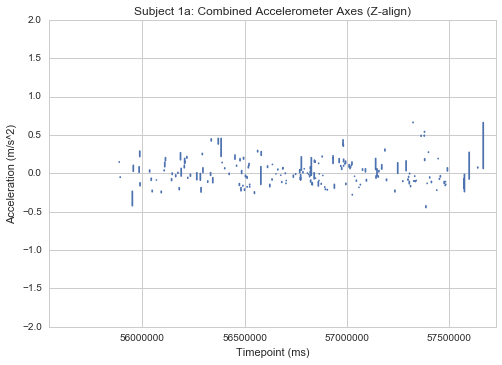

In [4]:
start,end = 55544580,57725830 # Session start and end times
first,last = np.where(df['t']==start)[0][0],np.where(df['t']==end)[0][0]+1
T = df['t'][first:last].values # Milliseconds
V = df['zalign'][first:last].values # Z-aligned

with sns.axes_style("whitegrid"):
    
    fig = plt.figure(); plt.clf()
    
    plt.plot(T,V)     
    
    plt.axis([start,end,-2,2])    
    plt.ticklabel_format(style='plain',axis='x')
    
    plt.xlabel("Timepoint (ms)")
    plt.ylabel("Acceleration (m/s^2)")
    plt.title("Subject "+subject+": Combined Accelerometer Axes (Z-align)")
    
    plt.show()

## Time interpolation

Load combined axes timeseries.

In [15]:
dbase = sqlite3.connect("disco_parser.db")
dframe = pd.read_sql_query("SELECT id, t, vector, xalign, yalign, zalign FROM unprocessed",dbase)
dbase.close()
dframe.head()

,id,t,vector,xalign,yalign,zalign
0,1a,55544529,0.848296,-1.380608,0.178958,0.063700
1,1a,55544606,0.879040,-1.304258,0.250613,0.088850
2,1a,55544610,0.898784,-1.219847,0.340315,0.082427
3,1a,55544612,0.894711,-1.197218,0.357394,0.104132
4,1a,55544617,0.884743,-1.233875,0.299457,0.149755


Interpolate combined axes timeseries. (*Options:* linear, cubic, nearest)

In [16]:
def disco_interpolate(inputdata,combotype,outputdir,interptype,startstring,endstring):
    ''' Interpolates accelerometer timeseries
    inputdata = Input data table (id,t,v[vector/xalign/yalign/zalign])
    combotype = 'vector' / 'xalign' / 'yalign' / 'zalign'
    outputdir = Output data directory
    interptype = Interpolation type ('linear','cubic','nearest')
    startstring = Event start time (HH:MM:SS:MS)
    endstring = Event end time (HH:MM:SS:MS)
    Returns: timeseries = Interpolated values (id,t,v) '''
    
    function = 'disco_interpolate'
    print(time.strftime("%m/%d/%Y"),time.strftime("%H:%M:%S"),'Running',function,interptype)
    
    # Event start and end times in milliseconds
    startnumber = [int(num) for num in startstring.split(':')]
    endnumber = [int(num) for num in endstring.split(':')]
    starttime = startnumber[0]*60*60*1000 + startnumber[1]*60*1000 + startnumber[2]*1000 + startnumber[3]
    endtime = endnumber[0]*60*60*1000 + endnumber[1]*60*1000 + endnumber[2]*1000 + endnumber[3]
        
    subjects = inputdata.id.unique()
    
    timeseries = pd.DataFrame({})
    for s in subjects:
        
        print(time.strftime("%m/%d/%Y"),time.strftime("%H:%M:%S"),s)
        
        X = inputdata[inputdata.id == s].t.values # Sampled milliseconds
        Y = inputdata[inputdata.id == s].v.values # Sampled acceleration
        
        U,I = np.unique(X,return_index=True) # Find unique milliseconds
        X = X[I] # Remove duplicate milliseconds (i.e., 2 samples in 1 ms)
        Y = Y[I] # Remove corresponding acceleration samples
        
        if interptype == 'linear' or interptype == 'nearest':
            F = sp.interpolate.interp1d(X,Y,kind=interptype)
        elif interptype == 'cubic':
            F = sp.interpolate.PchipInterpolator(X,Y)
        
        XQ = np.arange(X[0],X[-1]+1) # Interpolated milliseconds
        YQ = F(XQ) # Interpolated acceleration samples
        
        startindex = np.where(XQ == starttime)[0][0]
        endindex = np.where(XQ == endtime)[0][0]
            
        temp = pd.DataFrame({'id':[s]*(endindex-startindex+1),
                             't':XQ[startindex:endindex+1],
                             'v':YQ[startindex:endindex+1]})       
        
        timeseries = pd.concat([timeseries,temp])
    
    outputfile = function+'_'+interptype+'_'+combotype+'.pkl'
    print(time.strftime("%m/%d/%Y"),time.strftime("%H:%M:%S"),'Saving',outputfile)
    timeseries.to_pickle(os.path.join('.',outputdir,outputfile))
    
    print(time.strftime("%m/%d/%Y"),time.strftime("%H:%M:%S"),'Done') 
    return timeseries

In [17]:
zalign = dframe[['id','t','zalign']].rename(columns={'zalign':'v'})
zalign.head()

,id,t,v
0,1a,55544529,0.063700
1,1a,55544606,0.088850
2,1a,55544610,0.082427
3,1a,55544612,0.104132
4,1a,55544617,0.149755


In [18]:
linear_zalign  = disco_interpolate(zalign,'zalign','', 'linear','15:25:44:580','16:02:05:830')
nearest_zalign = disco_interpolate(zalign,'zalign','','nearest','15:25:44:580','16:02:05:830')
cubic_zalign   = disco_interpolate(zalign,'zalign','',  'cubic','15:25:44:580','16:02:05:830')

11/08/2016 13:02:29 Running disco_interpolate linear
11/08/2016 13:02:29 1a
11/08/2016 13:02:30 1b
11/08/2016 13:02:31 2a
11/08/2016 13:02:32 2b
11/08/2016 13:02:32 3a
11/08/2016 13:02:33 3b
11/08/2016 13:02:35 4a
11/08/2016 13:02:36 4b
11/08/2016 13:02:37 5b
11/08/2016 13:02:38 6a
11/08/2016 13:02:39 6b
11/08/2016 13:02:41 Saving disco_interpolate_linear_zalign.pkl
11/08/2016 13:02:53 Done
11/08/2016 13:02:53 Running disco_interpolate nearest
11/08/2016 13:02:53 1a
11/08/2016 13:02:54 1b
11/08/2016 13:02:55 2a
11/08/2016 13:02:55 2b
11/08/2016 13:02:56 3a
11/08/2016 13:02:57 3b
11/08/2016 13:02:58 4a
11/08/2016 13:02:59 4b
11/08/2016 13:03:00 5b
11/08/2016 13:03:01 6a
11/08/2016 13:03:02 6b
11/08/2016 13:03:03 Saving disco_interpolate_nearest_zalign.pkl
11/08/2016 13:03:17 Done
11/08/2016 13:03:17 Running disco_interpolate cubic
11/08/2016 13:03:18 1a
11/08/2016 13:03:33 1b
11/08/2016 13:03:47 2a
11/08/2016 13:04:02 2b
11/08/2016 13:04:17 3a
11/08/2016 13:04:32 3b
11/08/2016 13:04:47 

In [19]:
linear_zalign.head()

,id,t,v
0,1a,55544580,0.080358
1,1a,55544581,0.080684
2,1a,55544582,0.081011
3,1a,55544583,0.081338
4,1a,55544584,0.081664


In [20]:
nearest_zalign.head()

,id,t,v
0,1a,55544580,0.08885
1,1a,55544581,0.08885
2,1a,55544582,0.08885
3,1a,55544583,0.08885
4,1a,55544584,0.08885


In [21]:
cubic_zalign.head()

,id,t,v
0,1a,55544580,0.087882
1,1a,55544581,0.087989
2,1a,55544582,0.088088
3,1a,55544583,0.088180
4,1a,55544584,0.088263


Line chart of the interpolated timeseries. (*Type:* linear)

In [2]:
# Load interpolated timeseries for subject
subject = '1a'
df = pd.read_pickle('disco_interpolate_linear_zalign.pkl')
df = df[df.id==subject]

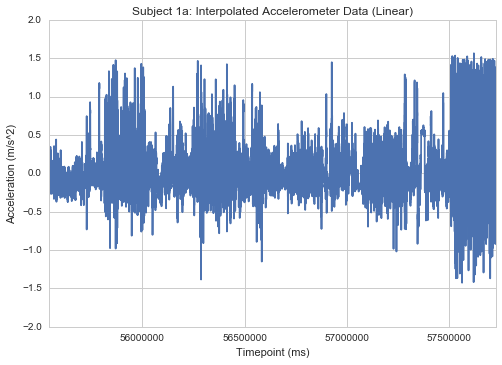

In [3]:
start,end = 55544580,57725830 # Session start and end times
first,last = np.where(df['t']==start)[0][0],np.where(df['t']==end)[0][0]+1
T = df['t'][first:last].values # Time
V = df['v'][first:last].values # Values

with sns.axes_style("whitegrid"):
    
    fig = plt.figure(); plt.clf()
    
    plt.plot(T,V)     
    
    plt.axis([start,end,-2,2])    
    plt.ticklabel_format(style='plain',axis='x')
    
    plt.xlabel("Timepoint (ms)")
    plt.ylabel("Acceleration (m/s^2)")
    plt.title("Subject "+subject+": Interpolated Accelerometer Data (Linear)")
    
    plt.show()

## Data downsampling

Load interpolated timeseries.

In [22]:
linear_zalign = pd.read_pickle('disco_interpolate_linear_zalign.pkl')
linear_zalign.head()

,id,t,v
0,1a,55544580,0.080358
1,1a,55544581,0.080684
2,1a,55544582,0.081011
3,1a,55544583,0.081338
4,1a,55544584,0.081664


Downsample interpolated timeseries back to actual average sampling rate. (*Options:* average, decimate)

In [25]:
def disco_downsample(indata,intype,outdir,outtype,newrate):
    ''' Downsamples timeseries data
    indata = Input data table (id,t,v)
    intype = ('linear','nearest','cubic') x ('vector','xalign','yalign','zalign')
    outdir = Output data directory
    outtype = Downsampling type ('average','decimate')
        - 'average': Replace each set of N samples by their mean
                  (Preserves temporal shape of waveform)
        - 'decimate': Apply a low-pass filter before resampling
                      (Preserves spectral information of waveform)
    newrate = New sampling rate in ms
        - e.g., ceil(mean of actual rate across Ss) = ceil(15.4120) = 16 ms
    Returns: timeseries = Downsampled values (id,t,v) '''
    
    function = 'disco_downsample'
    print(time.strftime("%m/%d/%Y"),time.strftime("%H:%M:%S"),'Running',function,outtype)
    
    subjects = indata.id.unique()
    
    timeseries = pd.DataFrame({})
    for s in subjects:
        
        print(time.strftime("%m/%d/%Y"),time.strftime("%H:%M:%S"),s)
        
        # Detrend timeseries first    
        det = sig.detrend(indata[indata.id==s].v.values) # Linear detrend

        # Pad timeseries with mean of last window so length divisible by 'newrate'
        # 'newrate' is rounded up from average sampling rate so not using a slightly faster sampling rate
        padTS = np.zeros(int(newrate*np.ceil(len(det)/newrate)))
        padTS[0:len(det)] = det
        padRM = len(det) % newrate # Last window
        padVL = len(padTS) - len(det) # Pad amount
        padTS[len(det):len(padTS)] = np.repeat(np.mean(det[len(det)-padRM:len(det)]),padVL)

        # Pad time information with additional milliseconds so length divisible by 'newrate'
        msec = indata[indata.id==s].t.values
        padMS = np.zeros(int(newrate*np.ceil(len(msec)/newrate)))
        padMS[0:len(msec)] = msec
        padVL = len(padMS) - len(msec) # Pad amount  
        padMS[len(msec):len(padMS)] = np.arange(msec[-1]+1,msec[-1]+1+padVL)

        # Mean timepoint for each new sample
        newMS = np.reshape(padMS,(int(len(padMS)/newrate),newrate))
        downMS = np.mean(newMS,axis=1)
        
        # Downsample timeseries
        if outtype == 'average': # Preserves temporal shape of waveform
            # Replace each set of of N (=newrate) samples by their mean
            newTS = np.reshape(padTS,(int(len(padTS)/newrate),newrate))
            downTS = np.mean(newTS,axis=1)        
        elif outtype == 'decimate': # Preserves spectral information of waveform
            # Resample at a lower rate after low-pass filtering (to prevent aliasing)
            downTS = sig.decimate(padTS,newrate)
        
        temp = pd.DataFrame({'id':[s]*len(downTS),
                             't':downMS,
                             'v':downTS})       
        
        timeseries = pd.concat([timeseries,temp])
    
    outfile = function+'_'+outtype+'_'+intype+'.pkl'
    print(time.strftime("%m/%d/%Y"),time.strftime("%H:%M:%S"),'Saving',outfile)
    timeseries.to_pickle(os.path.join('.',outdir,outfile))
    
    print(time.strftime("%m/%d/%Y"),time.strftime("%H:%M:%S"),'Done') 
    return timeseries      

In [26]:
average_linear_zalign  = disco_downsample(linear_zalign,'linear_zalign','','average',int(np.ceil(15.4120)))
decimate_linear_zalign = disco_downsample(linear_zalign,'linear_zalign','','decimate',int(np.ceil(15.4120)))

11/08/2016 13:17:12 Running disco_downsample average
11/08/2016 13:17:14 1a
11/08/2016 13:17:18 1b
11/08/2016 13:17:22 2a
11/08/2016 13:17:26 2b
11/08/2016 13:17:30 3a
11/08/2016 13:17:34 3b
11/08/2016 13:17:38 4a
11/08/2016 13:17:42 4b
11/08/2016 13:17:47 5b
11/08/2016 13:17:51 6a
11/08/2016 13:17:55 6b
11/08/2016 13:17:59 Saving disco_downsample_average_linear_zalign.pkl
11/08/2016 13:17:59 Done
11/08/2016 13:18:00 Running disco_downsample decimate
11/08/2016 13:18:01 1a
11/08/2016 13:18:05 1b
11/08/2016 13:18:09 2a
11/08/2016 13:18:13 2b
11/08/2016 13:18:18 3a
11/08/2016 13:18:22 3b
11/08/2016 13:18:26 4a
11/08/2016 13:18:30 4b
11/08/2016 13:18:34 5b
11/08/2016 13:18:38 6a
11/08/2016 13:18:42 6b
11/08/2016 13:18:46 Saving disco_downsample_decimate_linear_zalign.pkl
11/08/2016 13:18:47 Done


In [27]:
average_linear_zalign.head()

,id,t,v
0,1a,55544587.5,0.096531
1,1a,55544603.5,0.100724
2,1a,55544619.5,0.186774
3,1a,55544635.5,0.215599
4,1a,55544651.5,0.203376


In [28]:
decimate_linear_zalign.head()

,id,t,v
0,1a,55544587.5,8.542811e-12
1,1a,55544603.5,1.846869e-04
2,1a,55544619.5,1.369462e-02
3,1a,55544635.5,7.903322e-02
4,1a,55544651.5,1.256160e-01


Line chart of the downsampled timeseries. (*Type:* average)

In [2]:
# Load downsampled timeseries for subject
subject = '1a'
df = pd.read_pickle('disco_downsample_average_linear_zalign.pkl')
df = df[df.id==subject]

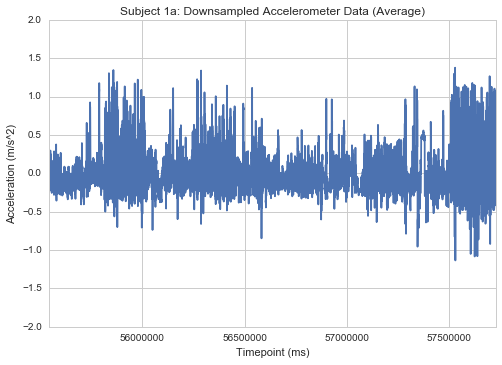

In [3]:
start,end = 55544580,57725830 # Session start and end times
first,last = np.where(df['t']>=start)[0][0],np.where(df['t']>=end)[0][-1]+1
T = df['t'][first:last].values # Time
V = df['v'][first:last].values # Values

with sns.axes_style("whitegrid"):
    
    fig = plt.figure(); plt.clf()
    
    plt.plot(T,V)     
    
    plt.axis([start,end,-2,2])    
    plt.ticklabel_format(style='plain',axis='x')
    
    plt.xlabel("Timepoint (ms)")
    plt.ylabel("Acceleration (m/s^2)")
    plt.title("Subject "+subject+": Downsampled Accelerometer Data (Average)")
    
    plt.show()

## Wavelet decomposition

Load downsampled timeseries.

In [29]:
average_linear_zalign = pd.read_pickle('disco_downsample_average_linear_zalign.pkl')
average_linear_zalign.head()

,id,t,v
0,1a,55544587.5,0.096531
1,1a,55544603.5,0.100724
2,1a,55544619.5,0.186774
3,1a,55544635.5,0.215599
4,1a,55544651.5,0.203376


Wavelet decomposition of downsampled timeseries. (*Options:* coif1/2/3, db2/4/6, sym2/4/6)

In [177]:
def disco_decompose(indata,intype,outdir,outtype):
    ''' Wavelet decomposition of timeseries data
    indata = Input data table (id,t,v)
    intype = ('ave','dec') x ('lin','nea','cub') x ('vec','xal','yal','zal')
    outdir = Output data directory
    outtype = Wavelet to use (coif1/3/5,db2/4/6,sym2/4/6)
    Returns: timeseries = Decomposed values (id,t,v0,v1...vn) '''
    
    function = 'disco_decompose'
    print(time.strftime("%m/%d/%Y"),time.strftime("%H:%M:%S"),'Running',function,outtype)
    
    subjects = indata.id.unique()
    
    timeseries = pd.DataFrame({})
    for s in subjects:
        
        print(time.strftime("%m/%d/%Y"),time.strftime("%H:%M:%S"),s)

        # Number of levels in wavelet transformation
        # levels = floor(log2(length(old{1,1}(:,1)))); 

        # modwt: Maximal overlap discrete wavelet transform
        # i.e., Stationary wavelet transform (SWT)
        # W = modwt(X,WNAME): modwt of a signal X using the wavelet WNAME
        # W: LEV+1-by-N matrix of wavelet coeffs & final-level scaling coeffs
        # LEV: Level of the modwt
        # m-th row: Wavelet (detail) coefficients for scale 2^m
        # LEV+1-th row: Scaling coefficients for scale 2^LEV

        # imodwt: Inverse maximal overlap discrete wavelet transform
        # R = imodwt(W,Lo,Hi): Reconstructs signal using scaling filter Lo & wavelet filter Hi
        
        # pywt.swt from PyWavelets only works for input length divisible by 2**level
        # Defeats the purpose of MODWT, which is supposed to be able to take input of any length
        
        # modwt_transform and inverse_modwt_transform from PyMultiscale
        # Looks like a decent alternative, but unable to run Cython code
        
        D = indata[indata.id==s].v.values # Timeseries data
        D = sp.stats.zscore(D) # Normalization: mean = 0, variance = 1
        
        lev = int(np.floor(np.log2(len(D)))) # Maximum number of levels
        rem = int(len(D) % 2**lev) # Samples to remove so divisible by 2^levels        
        W = pywt.swt(D[:-rem],outtype) # Wavelet coefficients
        
        R = {}
        for L in range(lev):            
            R['L'+str(L).zfill(2)] = pywt.iswt([W[lev-L-1]],outtype) # Reconstructed signal at each level        
        R = pd.DataFrame(R)
        
        temp = pd.DataFrame({'id':indata[indata.id==s].id.values[:-rem],
                             't':indata[indata.id==s].t.values[:-rem]})
        temp = pd.concat([temp,R],axis=1)
        
        timeseries = pd.concat([timeseries,temp])
    
    outfile = function+'_'+outtype+'_'+intype+'.pkl'
    print(time.strftime("%m/%d/%Y"),time.strftime("%H:%M:%S"),'Saving',outfile)
    timeseries.to_pickle(os.path.join('.',outdir,outfile))
    
    print(time.strftime("%m/%d/%Y"),time.strftime("%H:%M:%S"),'Done') 
    return timeseries   

In [178]:
coif1_average_linear_zalign  = disco_decompose(average_linear_zalign,'average_linear_zalign','','coif1')
sym4_average_linear_zalign   = disco_decompose(average_linear_zalign,'average_linear_zalign','','sym4')
db6_average_linear_zalign    = disco_decompose(average_linear_zalign,'average_linear_zalign','','db6')

11/08/2016 22:27:46 Running disco_decompose coif1
11/08/2016 22:27:46 1a
11/08/2016 22:28:55 1b
11/08/2016 22:30:04 2a
11/08/2016 22:31:13 2b
11/08/2016 22:32:22 3a
11/08/2016 22:33:31 3b
11/08/2016 22:34:40 4a
11/08/2016 22:35:49 4b
11/08/2016 22:36:59 5b
11/08/2016 22:38:08 6a
11/08/2016 22:39:17 6b
11/08/2016 22:40:26 Saving disco_decompose_coif1_average_linear_zalign.pkl
11/08/2016 22:40:30 Done
11/08/2016 22:40:30 Running disco_decompose sym4
11/08/2016 22:40:30 1a
11/08/2016 22:42:18 1b
11/08/2016 22:44:07 2a
11/08/2016 22:45:54 2b
11/08/2016 22:47:44 3a
11/08/2016 22:49:32 3b
11/08/2016 22:51:20 4a
11/08/2016 22:53:09 4b
11/08/2016 22:54:57 5b
11/08/2016 22:56:45 6a
11/08/2016 22:58:33 6b
11/08/2016 23:00:22 Saving disco_decompose_sym4_average_linear_zalign.pkl
11/08/2016 23:00:26 Done
11/08/2016 23:00:26 Running disco_decompose db6
11/08/2016 23:00:26 1a
11/08/2016 23:03:38 1b
11/08/2016 23:06:54 2a
11/08/2016 23:10:07 2b
11/08/2016 23:13:20 3a
11/08/2016 23:16:40 3b
11/08/2016

In [179]:
coif1_average_linear_zalign.head()

,id,t,L00,L01,L02,L03,L04,L05,L06,L07,L08,L09,L10,L11,L12,L13,L14,L15,L16
0,1a,55544587.5,0.437819,0.363623,0.750461,0.706682,0.595032,1.382487,1.856779,-1.264673,-1.554573,-0.832260,0.025133,1.238817,3.034769,-6.937689,1.216199,3.843380,-3.213427
1,1a,55544603.5,0.456833,0.755834,1.077211,0.763299,0.679155,1.311234,1.873680,-1.247859,-1.545647,-0.847035,0.015576,1.231296,3.022003,-6.938942,1.215734,3.843811,-3.213433
2,1a,55544619.5,0.847117,1.148380,1.277645,0.878457,0.779679,1.218174,1.890706,-1.227848,-1.536669,-0.861238,0.006042,1.223817,3.009260,-6.940178,1.215276,3.844243,-3.213430
3,1a,55544635.5,0.977855,1.293980,1.357916,0.956800,0.835278,1.108216,1.900371,-1.208144,-1.530187,-0.876722,-0.004249,1.216065,2.996350,-6.941457,1.214779,3.844666,-3.213433
4,1a,55544651.5,0.922416,1.334348,1.350304,0.956692,0.856806,0.981870,1.905511,-1.189794,-1.525169,-0.892329,-0.014608,1.208243,2.983409,-6.942738,1.214269,3.845101,-3.213432


In [180]:
sym4_average_linear_zalign.head()

,id,t,L00,L01,L02,L03,L04,L05,L06,L07,L08,L09,L10,L11,L12,L13,L14,L15,L16
0,1a,55544587.5,0.437819,1.250944,1.055379,0.451627,0.053883,-1.507825,-1.486019,0.873301,1.157404,-4.581644,-4.957439,-22.533522,-23.453973,27.168741,20.807763,-14.849183,-3.21343
1,1a,55544603.5,0.456833,1.399894,0.807249,0.425587,-0.052548,-1.473509,-1.500158,0.894372,1.141550,-4.582942,-4.961307,-22.536188,-23.448745,27.172373,20.807739,-14.849832,-3.21343
2,1a,55544619.5,0.847117,1.413463,0.524951,0.431011,-0.159814,-1.435229,-1.514544,0.915735,1.125594,-4.584216,-4.965187,-22.538852,-23.443516,27.176003,20.807716,-14.850480,-3.21343
3,1a,55544635.5,0.977855,1.114347,0.265457,0.451296,-0.268670,-1.391796,-1.528887,0.937424,1.109524,-4.585468,-4.969079,-22.541515,-23.438288,27.179633,20.807693,-14.851128,-3.21343
4,1a,55544651.5,0.922416,0.729264,0.052103,0.468701,-0.375418,-1.343825,-1.542602,0.959426,1.093410,-4.586686,-4.972977,-22.544175,-23.433059,27.183262,20.807671,-14.851776,-3.21343


In [181]:
db6_average_linear_zalign.head()

,id,t,L00,L01,L02,L03,L04,L05,L06,L07,L08,L09,L10,L11,L12,L13,L14,L15,L16
0,1a,55544587.5,0.437819,-0.236594,0.514791,3.993763,-7.875763,-0.190633,-1.304937,12.622744,11.831024,10.384148,16.777759,-12.643656,-6.406916,-22.400745,15.721125,9.887548,-3.21343
1,1a,55544603.5,0.456833,-0.187709,0.503053,3.834404,-7.785364,-0.114232,-1.249157,12.585242,11.815590,10.345099,16.781789,-12.659487,-6.405822,-22.401695,15.722296,9.886624,-3.21343
2,1a,55544619.5,0.847117,-0.358095,0.499447,3.673776,-7.675673,-0.039270,-1.192057,12.546716,11.800023,10.306066,16.785812,-12.675318,-6.404726,-22.402645,15.723468,9.885699,-3.21343
3,1a,55544635.5,0.977855,-0.722347,0.514644,3.511521,-7.546513,0.034239,-1.133693,12.507159,11.784324,10.267049,16.789831,-12.691149,-6.403629,-22.403595,15.724639,9.884775,-3.21343
4,1a,55544651.5,0.922416,-0.691024,0.502628,3.352949,-7.396301,0.106189,-1.074164,12.466567,11.768490,10.228046,16.793844,-12.706981,-6.402530,-22.404545,15.725811,9.883851,-3.21343


Line chart of the decomposed timeseries. (*Type:* coif1)

In [2]:
# Load decomposed timeseries for subject
subject = '1a'
df = pd.read_pickle('disco_decompose_coif1_average_linear_zalign.pkl')
df = df[df.id==subject]

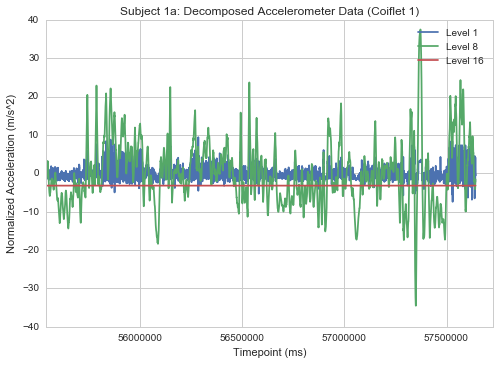

In [5]:
start,end = 55544580,57725830 # Session start and end times
first,last = 0,-1
T = df['t'][first:last].values # Time
L01 = df['L01'][first:last].values # Level 1
# L04 = df['L04'][first:last].values # Level 4
L08 = df['L08'][first:last].values # Level 8
# L12 = df['L12'][first:last].values # Level 12
L16 = df['L16'][first:last].values # Level 16

with sns.axes_style("whitegrid"):
    
    fig = plt.figure(); plt.clf()
    
    plt.plot(T,L01,label='Level 1')
    # plt.plot(T,L04,label='Level 4')
    plt.plot(T,L08,label='Level 8')
    # plt.plot(T,L12,label='Level 12')
    plt.plot(T,L16,label='Level 16')
    
    plt.axis([start,end,-40,40])    
    plt.ticklabel_format(style='plain',axis='x')
    
    plt.legend()
    plt.xlabel("Timepoint (ms)")
    plt.ylabel("Normalized Acceleration (m/s^2)")
    plt.title("Subject "+subject+": Decomposed Accelerometer Data (Coiflet 1)")
    
    plt.show()